### Training Contextual Bandits through (Full) Batch Method, Logistic Regression Cls Learner

In [1]:

import os
import re
import sys
import json
import time
#import config
import spotipy
import pandas as pd
from tqdm import tqdm
from datetime import datetime
from spotipy.oauth2 import SpotifyClientCredentials, SpotifyOAuth

In [2]:
import pandas as pd
import glob
import os

path = r'new data/training_set' # use your path

In [3]:
import pickle
#df_cd.to_pickle("new data/full_dataset.pkl")
full_data = pd.read_pickle("new data/full_dataset.pkl")

In [4]:
full_data = full_data.drop(columns=['session_position'])

In [5]:
full_data.head()

,session_id,track_id,context_switch,no_pause_before_play,short_pause_before_play,long_pause_before_play,hist_user_behavior_n_seekfwd,hist_user_behavior_n_seekback,hist_user_behavior_is_shuffle,premium,...,time_signature,valence,acoustic_vector_0,acoustic_vector_1,acoustic_vector_2,acoustic_vector_3,acoustic_vector_4,acoustic_vector_5,acoustic_vector_6,acoustic_vector_7
0,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
1,62_0000928f-d177-49a3-bb3a-34c950d0a7f7,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,1,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
2,62_03d8ebcd-e5e1-41a0-966b-258d296d8af7,t_46c04497-7db9-461f-a78b-be47de38e659,0,0,1,1,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
3,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704
4,62_04d0781a-278f-48ce-b5d7-ceaeb37f3dd0,t_46c04497-7db9-461f-a78b-be47de38e659,0,1,0,0,0,0,0,1,...,4,0.325417,-0.813393,0.356924,0.181721,0.035198,-0.273374,-0.018502,-0.469811,0.177704


In [6]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11793444 entries, 0 to 11793443
Data columns (total 40 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   session_id                     object 
 1   track_id                       object 
 2   context_switch                 int64  
 3   no_pause_before_play           int64  
 4   short_pause_before_play        int64  
 5   long_pause_before_play         int64  
 6   hist_user_behavior_n_seekfwd   int64  
 7   hist_user_behavior_n_seekback  int64  
 8   hist_user_behavior_is_shuffle  int32  
 9   premium                        int32  
 10  skipped                        int32  
 11  duration                       float64
 12  release_year                   int64  
 13  us_popularity_estimate         float64
 14  acousticness                   float64
 15  beat_strength                  float64
 16  bounciness                     float64
 17  danceability                   float64
 18  

In [7]:
c

In [8]:
def preprocess_tracks(df, min_number_of_plays=5000):
        # remove ratings of movies with < N plays. 
        tracks_to_keep = pd.DataFrame(df.track_id.value_counts()).loc[pd.DataFrame(df.track_id.value_counts())['track_id']>=min_number_of_plays].index
        df = df.loc[df['track_id'].isin(tracks_to_keep)]
        return df

In [9]:
data_preprocessed =  preprocess_tracks(full_data, min_number_of_plays=5000)
print(len(data_preprocessed))

1535450


In [10]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import StandardScaler

y = np.array(data_preprocessed.skipped)
X=np.array(data_preprocessed .drop(
    columns=["skipped","session_id","track_id"], axis=1
))
print (y.shape)
#scaled_data = StandardScaler().fit_transform(X); scalling data does not improve learner's (predictive model) perfomance 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.994, random_state=42, stratify=y)
print (y_train.shape)

(1535450,)
(9212,)


In [11]:
y_train.shape[0]

9212

In [12]:
# checking is classes are balanced
counts = np.unique(y_train, return_counts=True)
counts

(array([0, 1]), array([4857, 4355], dtype=int64))

In [13]:
from sklearn.preprocessing import StandardScaler

In [14]:
X_train = StandardScaler().fit_transform(X_train) 

In [15]:
nchoices = y_train.shape[0]

In [16]:
nchoices

9212

Batch Evaluation

In [17]:
from sklearn.linear_model import LogisticRegression
from contextualbandits.online import BootstrappedUCB, BootstrappedTS,  SeparateClassifiers, EpsilonGreedy, AdaptiveGreedy, ExploreFirst, ActiveExplorer, SoftmaxExplorer
from copy import deepcopy

nchoices = y_train.shape[0]
base_algorithm = LogisticRegression(solver='lbfgs', warm_start=True)
beta_prior = ((3./nchoices, 4), 2) # until there are at least 2 observations of each class, will use this prior
beta_prior_ucb = ((5./nchoices, 4), 2) # UCB gives higher numbers, thus the higher positive prior
beta_prior_ts = ((2./np.log2(nchoices), 4), 2)

## The base algorithm is embedded in different metaheuristics
bootstrapped_ucb = BootstrappedUCB(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior = beta_prior_ucb, percentile = 80)
bootstrapped_ts = BootstrappedTS(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior = beta_prior_ts)
one_vs_rest = SeparateClassifiers(deepcopy(base_algorithm), nchoices = nchoices,
                                      beta_prior = beta_prior)
epsilon_greedy = EpsilonGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                   beta_prior = beta_prior)
#logistic_ucb = LogisticUCB(nchoices = nchoices, percentile = 70,
                              # beta_prior = beta_prior_ts, random_state = 5555) # does not work for some reason in v 0.3
adaptive_greedy_thr = AdaptiveGreedy(deepcopy(base_algorithm), nchoices=nchoices,
                                         decay_type='threshold',
                                        beta_prior = beta_prior)
adaptive_greedy_perc = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                          decay_type='percentile', decay=0.9997,
                                          beta_prior=beta_prior)
explore_first = ExploreFirst(deepcopy(base_algorithm), nchoices = nchoices,
                                 explore_rounds=1500, beta_prior=None)
active_explorer = ActiveExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                     beta_prior=beta_prior)
adaptive_active_greedy = AdaptiveGreedy(deepcopy(base_algorithm), nchoices = nchoices,
                                            active_choice='weighted', decay_type='percentile', decay=0.9997,
                                            beta_prior=beta_prior)
softmax_explorer = SoftmaxExplorer(deepcopy(base_algorithm), nchoices = nchoices,
                                       beta_prior=beta_prior)
    
models = [bootstrapped_ucb, bootstrapped_ts, one_vs_rest, epsilon_greedy, adaptive_greedy_thr, adaptive_greedy_perc, explore_first, active_explorer, adaptive_active_greedy, softmax_explorer]

In [20]:
 # These lists will keep track of the rewards obtained by each policy\n",
rewards_ucb, rewards_ts, rewards_ovr, rewards_egr, rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft = [list() for i in range(len(models))]
lst_rewards = [rewards_ucb, rewards_ts, rewards_ovr, rewards_egr,  rewards_agr, rewards_agr2, rewards_efr, rewards_ac, rewards_aac, rewards_sft]
# batch size - algorithms will be refit after N rounds
batch_size = 50

# initial seed - all policies start with the same small random selection of actions/rewards
first_batch = X_train[:batch_size, :]
np.random.seed(1)
y_train = np.reshape(y_train, (-1, 1))
action_chosen = np.random.randint(nchoices, size=batch_size)
print(action_chosen)
rewards_received = []
for action in action_chosen:
    rewards_received.append(int(y_train[action]))
print(rewards_received)

# fitting models for the first time, on random context X and its corresponding rewards
for model in models:
     model.fit(X=first_batch, a=action_chosen, r=np.array(rewards_received))
        
# these lists will keep track of which actions does each policy choose
lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr,lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft = [action_chosen.copy() for i in range(len(models))]

lst_actions = [lst_a_ucb, lst_a_ts, lst_a_ovr, lst_a_egr, lst_a_agr, lst_a_agr2, lst_a_efr, lst_a_ac, lst_a_aac, lst_a_sft]


# rounds are simulated from the full dataset
def simulate_rounds(model, rewards, actions_hist, X_global, y_global, batch_st, batch_end):
    np.random.seed(batch_st)

    ## choosing actions for this batch
    actions_this_batch = model.predict(X_global[batch_st:batch_end, :]).astype('uint8')
    print(actions_this_batch)

  
    # adding this batch to the history of selected actions
    new_actions_hist = np.append(actions_hist, actions_this_batch)
    print(new_actions_hist)
    rewards_batch = []
    for action in actions_this_batch:
        rewards_batch.append(int(y_global[action]))
    
    # keeping track of the sum of rewards received
    rewards.append(sum(rewards_batch))
    
    # refitting the algorithms after observing these new rewards
    np.random.seed(batch_st)
    print(len(X_global[:batch_end, :]))
    print(len(new_actions_hist))
    
    new_rewards_hist = []
    for action in new_actions_hist:
        new_rewards_hist.append(int(y_global[action]))
    model.fit(X_global[:batch_end, :], new_actions_hist, np.array(new_rewards_hist))  #  y_global[:batch_end, :] np.array(rewards_batch

    return new_actions_hist

#running all the simulation
for i in range(int(np.floor(X_train.shape[0] / batch_size))):
    batch_st = (i + 1) * batch_size
    batch_end = (i + 2) * batch_size
    batch_end = np.min([batch_end, X_train.shape[0]])

    for model in range(len(models)):
        lst_actions[model] = simulate_rounds(models[model],
                                                 lst_rewards[model],
                                                 lst_actions[model],
                                                 X_train, y_train,
                                                 batch_st, batch_end)

[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046]
[0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1]
[115 241  20  22  58 156 198 109 196 141 198 141 129  50  22  15  20 109
 141 196  15 234 109 141  12 129 241 196  20 215 156 252 241 241 233 109
  50  22  76 129 129 139 175 141 141  15  26 141  20  50]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241

[112 165 192  38 245  86 202 204 110 237  74  38  27 209 108  91 223  83
 156 185 140 191 121 167   4 162 224  74  70  76 135 246 196 111  22   0
 209  84 135 191  21 161 138 132  65 206 198 140  16 186]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  165   92  131  241    6   73
   48   74  172  117  215  130   71  161   11   18  139   38    2   20
  216  215  245  167  185   28  137  221  191  217  227   22  107    4
  110  178   25   72  175  233  137  156  147  226   72   73    0   15
   85  160  112  165  192   38  245   86  202  204  110  237   74   38
   27  209  108   91  223   83  156  185  140  191  121  167    4  162
  224   74   70   76  135  246  196  111   22    0  209   84  135  191
   21  161  138  132   65  206  198  140   16  186]
150
150
[141 234  22 109  20 141 1

[141 141 141 141  20 141  20  15 141  50 141 109  20  20 141 141 109 109
  20 141 141  20  20 109 141 141  50  20 141 141 141 141 141  15 141 141
 141 141  15 141 109 141 141 141  20 141 141 141 109  20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[ 50 109 109 109 109 109  50 109 109  20  50  76 109 109 109 141 109 141
 141  50 109 141 109 109 109 109 109 109 109 109  20  20 109 156 141 109
  50  50  50 109  50 109 109 252 109  50  50 109 109 109]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   26  196   20  133  241   22
  129  216  198   50   22   26  198  196   76   71   22  109  109  141
  109   50  196  109  115   22  241  198  252  175  175  156   22  196
   20  215  109  252   50  141  241   22  216   22  252  216  215  141
   76   22  129  109   50   50  202  215   50  109  141  141  196  109
  141  109  109  109  156   50  109  105  109   20  109   22   50   20
  141  109  216  109  141  109  175  115   50  215  109  109   20   50
  109   50   26  147   20  234   20  156  215  109   50  109  109  109
  109  109   50

[141 141 141 141 141  50 141 141 141 141 141 141 141  15 141 141 141 141
  20 141 141  50 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141  50  50  15 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[141 141  20 141 141 141  20 141 141 141 141 141 141 141  15 141 141 141
 141 141 141 141 141  15 141 141 141 141 141 141 141 141 141  20 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 156 234 234 234 234 234 234 234 156 234 234 234 234 234 234 234 234 234
 109 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  196  109  234  215  115  175
  196   22  109  175    1  115  198   22  234  233   22  175   22  196
  241  241  156  241   15  115   71   20  215   22  234   76  216  196
  233  175   50   22  141   51  156  198   26  175   50  252  115  216
   71  233  141  252  241  156  234  234  109  233   22  233  216  234
  156   22  233   22  234   15  156   20  109   71   50  234  234  234
  234  129  109   26   20  109  198  234  241   15  109   15   76  109
  234  234  233   20  234  252  215  109   15  156  234   15  234  234
  109  234  156

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141  20 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 156 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 156 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  196  109  234  215  115  175
  196   22  109  175    1  115  198   22  234  233   22  175   22  196
  241  241  156  241   15  115   71   20  215   22  234   76  216  196
  233  175   50   22  141   51  156  198   26  175   50  252  115  216
   71  233  141  252  241  156  234  234  109  233   22  233  216  234
  156   22  233   22  234   15  156   20  109   71   50  234  234  234
  234  129  109   26   20  109  198  234  241   15  109   15   76  109
  234  234  233   20  234  252  215  109   15  156  234   15  234  234
  109  234  156

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141  20 141 141 141  20 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141  50 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[128 158 112 124 198  30 176 126 198  99 130 248 170  76  77 200 180  88
 218  47 179 133 201 242 222  86 191 134  65 173  34 188  45   1 119 180
  34  43 241  34  30 137 154 186  49 180 187 187 102 101]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[ 20   4  20  20  20  20 181 237  20 109  20  20  15 109  20  20  20  20
  20   8  20  20 109  20 183  20  20  20  77  20  20 109  20 177  20  20
  20  20 199 100  20  12 221  20  20  20  20  20  20  20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  119   22   56   22   22
   22   20  156   42  196   22  135  233  196   26   22   22  129  210
   50  190   20   15   50  115   15  161   15  140   20  241   65  241
   71  141  156  234  215  156   22  109  109  175  215  109  175  113
   20  109   15   76   15  115  167   20  186  156  109  175   20   20
   15   20   20  254   20   20  109  196   26   57   15   15  156  245
  109    1   19   50   50   69  125  182  109   12  156   24  176   50
  109  109  143   39   60  215  109  145   20   15   20  109   20  123
  245  237   50

[131 214  97  94 238  54 228  64  66 113 163  92  30 123 162 214 120  78
 228  99 146 213 148  66  50 232 183   9  63  33 148 217  86 201 239 247
  86  13 241  47  37 101  54  82 152  86 105 167  59 109]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[141 141  15  15  15  15  15  15 109  15  15  15 175  15 234 109 109  15
  15 207 109 109 141  15 141 234 234 141 109 156  15 141  15  15 109 109
  15 234 234  15 234  15  15 234 234  15  15  15  20 109]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  198  234   15   22   22
  129  109  101  196   22  109  215  233   22  198  175   15   15  141
   50  216  234  156  141  233  233  216  215  109   91   15  252  234
   85   22  233  233  129  252  198  175   68  115  141  207  141   70
   15  141   15   76  141  141   91   20   15  234   22  197  141   22
   26  141  196   76   98  233  141   50   15  234  252  198   15   91
   26  156  141  109  129   15  109  207   83   26  196  198   91   22
   50   20  233  175  234  156   20  141   22  141  234  234  109  234
   15   20   91

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  196  109  234  215  115  175
  196   22  109  175    1  115  198   22  234  233   22  175   22  196
  241  241  156  241   15  115   71   20  215   22  234   76  216  196
  233  175   50   22  141   51  156  198   26  175   50  252  115  216
   71  233  141  252  241  156  234  234  109  233   22  233  216  234
  156   22  233   22  234   15  156   20  109   71   50  234  234  234
  234  129  109   26   20  109  198  234  241   15  109   15   76  109
  234  234  233   20  234  252  215  109   15  156  234   15  234  234
  109  234  156

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[ 38  38 172  38 172 172 172  38 172 172 172 172 172  38  38  38 172  38
 172 172  38  38 172  38  38  38  38  38  38  38 172 161  38  38  38  38
 172 210 172  38 172 172 172 172 172 172  38  38 172  38]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  165   92  131  241    6   73
   48   74  172  117  215  130   71  161   11   18  139   38    2   20
  216  215  245  167  185   28  137  221  191  217  227   22  107    4
  110  178   25   72  175  233  137  156  147  226   72   73    0   15
   85  160  112  165  192   38  245   86  202  204  110  237   74   38
   27  209  108   91  223   83  156  185  140  191  121  167    4  162
  224   74   70   76  135  246  196  111   22    0  209   84  135  191
   21  161  138  132   65  206  198  140   16  186  218  252  204   56
  106   20  202

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[109 109 109 109 109 109 109 109 129 109  50 109 109 109 109 109 109 109
 109 109 109 109 109 109 141 141 109 109 109  50 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   26  196   20  133  241   22
  129  216  198   50   22   26  198  196   76   71   22  109  109  141
  109   50  196  109  115   22  241  198  252  175  175  156   22  196
   20  215  109  252   50  141  241   22  216   22  252  216  215  141
   76   22  129  109   50   50  202  215   50  109  141  141  196  109
  141  109  109  109  156   50  109  105  109   20  109   22   50   20
  141  109  216  109  141  109  175  115   50  215  109  109   20   50
  109   50   26  147   20  234   20  156  215  109   50  109  109  109
  109  109   50

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[109  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
 201 202  20 109  20  20  20  20 253  20  20  20  50  20  20 134 245  20
  20  20  20  20 109  20  20  20  20  20  20 187 109  20]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   20  119   22   56   22   22
   22   20  156   42  196   22  135  233  196   26   22   22  129  210
   50  190   20   15   50  115   15  161   15  140   20  241   65  241
   71  141  156  234  215  156   22  109  109  175  215  109  175  113
   20  109   15   76   15  115  167   20  186  156  109  175   20   20
   15   20   20  254   20   20  109  196   26   57   15   15  156  245
  109    1   19   50   50   69  125  182  109   12  156   24  176   50
  109  109  143   39   60  215  109  145   20   15   20  109   20  123
  245  237   50

[ 97 230 120  47 188  40 120  89 253  55  94 187  88 241  73 121 177 119
 239  12  37 174 255 154 236 125 109 161 138 104 170  31  30 176  64 243
  48 232 237 175 175  84 149 183  66 158  12 138   7  88]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[ 20 141 109  15  15 109 109  15 141  91  15  20 109 109  15 141 141 109
  15 141 141  15  91 141  15  15 156  15  91 207 156  15  15 156  15 141
  15 109  15  20 141 234 234 109  15 109  15  15  20  15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  198  234   15   22   22
  129  109  101  196   22  109  215  233   22  198  175   15   15  141
   50  216  234  156  141  233  233  216  215  109   91   15  252  234
   85   22  233  233  129  252  198  175   68  115  141  207  141   70
   15  141   15   76  141  141   91   20   15  234   22  197  141   22
   26  141  196   76   98  233  141   50   15  234  252  198   15   91
   26  156  141  109  129   15  109  207   83   26  196  198   91   22
   50   20  233  175  234  156   20  141   22  141  234  234  109  234
   15   20   91

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  196  109  234  215  115  175
  196   22  109  175    1  115  198   22  234  233   22  175   22  196
  241  241  156  241   15  115   71   20  215   22  234   76  216  196
  233  175   50   22  141   51  156  198   26  175   50  252  115  216
   71  233  141  252  241  156  234  234  109  233   22  233  216  234
  156   22  233   22  234   15  156   20  109   71   50  234  234  234
  234  129  109   26   20  109  198  234  241   15  109   15   76  109
  234  234  233   20  234  252  215  109   15  156  234   15  234  234
  109  234  156

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[172 172 172  38  38  38 172  38 172 172 172 172 172 172  38  38  38 172
  38 172 172 172 172  38 172 172 172 172  38  38 172  38 172  38  38 172
 172 172 172  38  38 172 172 172  38  38 172  38  38  38]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  165   92  131  241    6   73
   48   74  172  117  215  130   71  161   11   18  139   38    2   20
  216  215  245  167  185   28  137  221  191  217  227   22  107    4
  110  178   25   72  175  233  137  156  147  226   72   73    0   15
   85  160  112  165  192   38  245   86  202  204  110  237   74   38
   27  209  108   91  223   83  156  185  140  191  121  167    4  162
  224   74   70   76  135  246  196  111   22    0  209   84  135  191
   21  161  138  132   65  206  198  140   16  186  218  252  204   56
  106   20  202

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[109 109 109 109 109  20 109 109 109 109 109 109 109  50 109 109 109 109
 141 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109  20 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046   26  196   20  133  241   22
  129  216  198   50   22   26  198  196   76   71   22  109  109  141
  109   50  196  109  115   22  241  198  252  175  175  156   22  196
   20  215  109  252   50  141  241   22  216   22  252  216  215  141
   76   22  129  109   50   50  202  215   50  109  141  141  196  109
  141  109  109  109  156   50  109  105  109   20  109   22   50   20
  141  109  216  109  141  109  175  115   50  215  109  109   20   50
  109   50   26  147   20  234   20  156  215  109   50  109  109  109
  109  109   50

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[118  54  31 224 197 151 244 253 161  68 143 158  13 131 249 170  34  40
  48 241 202 200  14  36 126 107  36 138 157 229 242  19  58 155 111  66
 242 239 187   4  39 251 105 224 183 222 120  72  11 196]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[254  41   3  87 116  72  27  17 155  50 170 138 255 189  96  61 238  59
 110 136 113  23   4   4  66 235 232 245 137 209 172 146  99 198 158 210
 156 149 215 194  59 253 150 144 206 222  27 239 194 103]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[170  50 150 236  61 222  47 254 253 177 171 105 189 187 148  41 200 147
 199 146  50 116 107  39 168 186 153 227 255  67 217 203 187 231 125 215
   0  64 147 214   7 110 166 151 180 116 167  42  39 155]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[  1  44 178 172 164 104 188  89 214 114  40 162 160 242   5  41 135  75
 241 166  37  93 183 188   4 224  17 155 243  80  27 211  63 163 226 252
  61 253  52 197  30  24  57 181  92 191 202  78 177  46]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  115  241   20   22   58  156
  198  109  196  141  198  141  129   50   22   15   20  109  141  196
   15  234  109  141   12  129  241  196   20  215  156  252  241  241
  233  109   50   22   76  129  129  139  175  141  141   15   26  141
   20   50  141   15   15   22   20  109  141  215   20  141   50  109
  141   22  141   20  141  109  141  109  216   50  141   26  139  234
  109   20  109  141   20   15   15  141   50   20  109  141  156  141
  141   20  156  141  109  141   22  141  141   20  141  141  141  141
   20  141   20

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  216   76  129  115  198  175
  141   50  233  198  241  129   71  129  175   20  196   26   71  241
  219  234  198  196  241  198   20  196  115  241   20   76  175  141
  252   22  234   51  141  216  109  141  233   73   71  115   26  156
  196  153  141  234   22  109   20  141  141  156   22  109  175  141
  156  141  172  153  141  241   51  153   36  219  141  216   50  141
  234   50  196  234  215   51   20   50   20   50  216   71  141  141
  141   50   20   20  115   15   51  141  153  141  234   50  141   50
  141   50   22

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  215  175   26  141   50   20
  196   76  169   26   26  216  233  252  129  252  234   26   50   26
   15   76  241  175  115   71   22  141   20   15  216  129  141  241
  216  175  196  196  141  241  141   50  141  156   50  109  196  241
   22   22   50  141  141  215  141  141   50   50   20   50   20  141
  233  141  109   15  141   20  141  196  241   26  198  152  234  234
   15  141   20  141  141  141  141  216   50  141   50  141  129   26
   15  246   20   50  198  141   15   15  141  241  141   20   22   50
   50  141  141

[ 16  98 247 169   3 156 131 125 202   7  62 111  74 182  29 140 137  94
 108 132 221 115   8 121  64  98 253 197  48 235 150  93 181 141   1 176
 174  71 253 177 125 106 246 197  98  49 198 113  22 100]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  188  180  153  152  100  179
   76   53   56   63  217   38   79   53  186   21  176  218  232  179
   91  160   16  154  182  199  179   65   14   10  110  134  125  159
  201  144   54  217   67  123   86  234   60  183  205  185  183   91
  108   38  234   31  186   52   43  119   59  248  222  139  197  167
  163  226  123   14   10  231  189   58   64   44  202  103   36  244
  102   41   44  160  224   84  157  102  120   15  133  222  231  126
  160   57   76  193  145  222  109  187    0   43   21  128   19   83
  232  126   62

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 7813 2895 5056  144 4225 7751 3462 5396 5374 2962 2516
 8444 3562 4764 8093 6542  562 8151 3049  753 1888 1110 6285 6121 1031
 4415 2877 3606 2561 8920 6771  431 4074  542 1478 1337 7108 8689 1612
 3098 1844 2669   15 2244 7906 1306 1046  241   15   22   50  233   15
  175   22  241   22  175   22  156  198  215   76   15  233   26   15
  109  196   26   22   15  216   22   22   76  115  215   76  196   20
  234  252  196  129  241   76   15   22   15   71   22  156  175  115
  233  223   15   15   15   15   15   15  156  156   15   15   15   15
   15  234   15   15   15   71   26  109  233   15   15   50  216   15
   15   15  198  196  216   23   15   15   15   15   15   15   15   15
   15   12  196  156   15   20   15  156  196  109   15   15   15   15
   15   15   15   15   15   15   15   15   15   15  234   15   15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1050
1050
[ 38 172 172 172 172 172 172 172 172 172 172  38 172 172 172 172 172  38
  38  38  38 172  38  38 172 172 172 172 172 172 172 172  38 172 172 172
  38 172 172 172  38 172  38  38 172  38 172 172  38 172]
[ 235 5192  905 ...  172   38  172]
1050
1050
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1050
1050
[ 20  20  20 250 109  20  20  20  20  20  20  20  20  20  20  20  20 205
  20  20  20  20  16  20  20 193  20 196  20 180  20  20  20  20  20  20
  20  20  20  20  20 225  35  20  20  12  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
1050
1050


[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1200
1200
[234 234 234  60 234 234 234 234 234 234 234 234 234 234 234 231 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 139 234 234 234 234
 234  42 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
1200
1200
[234 219  45 244 116 163 206 182 239  94  72 253 234 202  20 126 182  22
 164  79  56 176 140  86 250 122 253  74 101 248 224  58 228  64  38 181
  40  60   5  22 155 112 133  14  16  97  24 161 154  44]
[ 235 5192  905 ...  161  154   44]
1200
1200
[202 109 109 109 109 109 109 109 109 109 109 109  50 109  20 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
1200
1200


[ 15  15  15  15  15  15  15  15  15  15  15 234  15  15  15  15  15  22
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
1350
1350
[141  15  15  15  15 141  15 141  15  15  15 109  15  15  15 141  15  15
 109 109  15 234  15  15  15  15  15  15  15  15 156  15  15  15 234 141
  15 141  15  15  15  15 109  15 109 109 141 141  15  15]
[ 235 5192  905 ...  141   15   15]
1350
1350
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1400
1400
[ 38 172 172  38 172 172 172  38 172 172 172  38  38 172 172 172 172  38
 172 172 172 172 172 172  38  38 172 172 172 172 172 172  38  38 172 172
 172 172 172  38 172 172 172 172 172  38 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
1400
1400


[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1550
1550
[ 20  20  20  20  20  20  20  20  20  20 179  20  20  20  20  20  20  20
  20  24  20  20  20  20  20  20  20  20  82  20 151  20  20  20  20  32
  20  20  20  20 100  20  20 109  20  20  20  20 254  20]
[ 235 5192  905 ...   20  254   20]
1550
1550
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1550
1550
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 241
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
1550
1550


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
1700
1700
[109 109 141 109 109 109  20 109 109 109 109 109 109  20 109  50 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109  20 109 109 109 109
 109 109  76 156 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
1700
1700
[ 15  15  15  15 156  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15 233  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
1700
1700
[ 15  15  15  15 109  15  15  15  15  15 156  15 141  15  15  15  15 141
  15  15 234 141  15  15  15  15  15 109  15 141 109  15  15  15 141  15
  15  15 109  15 234 109 141  15  15  15 109 109  15  15]
[ 235 5192  905 ...  109   15   15]
1700
1700
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141

[172  38 172 172 172 172 172 172 172 172 172 172 172  38 172 172 172 172
 172 172 172 172 172 172 172 172 172  38 172 172 172  38 172 172 172 172
 172 172 172 172 172 172  38 172  38 172  38  38 172 172]
[ 235 5192  905 ...   38  172  172]
1900
1900
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1900
1900
[ 20  20  20  20 200  20  20 223  20  20  20  20 172  20  20  20  20  20
  20  20  20  20  20  20  20  20  20 142  20  20  20  20  20  20  20  20
  20  20  20  20  20 214  20  20  20  20  20  20 148  20]
[ 235 5192  905 ...   20  148   20]
1900
1900
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
1900
1900


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2050
2050
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
2050
2050
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
2050
2050
[ 15  15  15 109  15 141  15  15  15  20  15  15 141  15 109 141  15  15
 141  15  15  15  15  15  15  15  15  15  15  15  15  15 109  15  15  15
  15  15  15  15  15 141  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
2050
2050
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 

[172 172 172 172 172 172 172 172 172 172  38  38  38 172 172 172 172 172
 172 172 172 172  38 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
2250
2250
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2250
2250
[ 20  20  20 170  20  20 119  98  20  20 101  20  20  20  20  20  20  20
   5 167  20  20  20  20  20  20  90  20  20  20  93  20  20  20  20  20
  20  20 154 173  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2250
2250
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2250
2250


[234 234 234 234 234 234 234 234 234 234 234 234 231 234 234 234 234 234
 234 234 107 234 234 234 234 234 234 234  43 234 234 234 234 234 234 234
 234 234 234 234  27 234 234 234 234 234 150 234 234 234]
[ 235 5192  905 ...  234  234  234]
2400
2400
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2400
2400
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 141 109 109 109 109 109 109 109 109 109 109 109 109  50 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
2400
2400
[ 15  15  20  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15 234  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
2400
2400
[ 15  15  15 141 109  15  15  15  15  15  15  15  15  15  15 109  15  15
  15  15  15 109  15  15  15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2600
2600
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172  38 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
2600
2600
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2600
2600
[ 20  20 255 144  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20 251  20  20  20 174  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2600
2600


[234 234 234 234 234 234 234 234 234 234 234 234  92 149 234 234 207 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 130 234 234 234 234 234 234 234 234  81 234 234]
[ 235 5192  905 ...   81  234  234]
2750
2750
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
2750
2750
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 141 109 109 109]
[ 235 5192  905 ...  109  109  109]
2750
2750
[ 15 156  15  15  20  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
2750
2750
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2950
2950
[172 172 172  38 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172  38 172 172]
[ 235 5192  905 ...   38  172  172]
2950
2950
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
2950
2950
[ 20  20  20  20  20  20  20  20 120  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20 191  20  20  20  51  20  20  20 225  20  20  20
  20  51  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
2950
2950


[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 223 234 234 234 234 234 234 246 234 234  23 234 234 234 118
 234 234 234 234 234 234 234 151 234 234 234 122 234 234]
[ 235 5192  905 ...  122  234  234]
3100
3100
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3100
3100
[109 109 109 156 109 109 109 109 109 109 109 109 109 109 109 109 109 141
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109  76 109]
[ 235 5192  905 ...  109   76  109]
3100
3100
[ 15  15  15  15  15  15  15  15  20  15  15 156  15  15  15  15  15  15
  20  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
3100
3100
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
3300
3300
[172 172 172 172  38 172 172 172  38 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
3300
3300
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
3300
3300
[ 20  20  20 217  20  20  20  20  20  20  20  21  20  20  20  20 205  20
  20  20 102  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20 180  20  20  20  20  20  20  79  20]
[ 235 5192  905 ...   20   79   20]
3300
3300


[234 234 234 234 234 145 234 234 234 234 234 234 234 234 234 234 234 186
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
  58  61 234 234 234 234 234 234 234 234 234 234  42 234]
[ 235 5192  905 ...  234   42  234]
3450
3450
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3450
3450
[109 109  20 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109  20 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
3450
3450
[15 15 15 15 15 15 15 15 15 15 20 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
3450
3450
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
 109  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
3650
3650
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
3650
3650
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
3650
3650
[ 20  20  20  20  20  20  20 199  20 233  20  20  20  68  20  20  20  20
 115  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20 249
  20  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
3650
3650


[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 142 234 234 234 234 234 234 234 234 198 234 234 234 234 191 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
3800
3800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
3800
3800
[109 109 109 109 109 109 109 109 109 109 109 109  20 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109  50 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
3800
3800
[ 15  15  15  15  15  15  15  15  15 109  15  15  20  15  15  15  15  15
  15  15  15 156  20  15  15  15  15  15  15  15 156  12  15  15 234  15
  15  15  15  15  15 234  15  15  15  15  15 109  15  15]
[ 235 5192  905 ...  109   15   15]
3800
3800
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 

[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
4000
4000
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4000
4000
[ 20  20  56  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20 164  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20 226  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
4000
4000
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4000
4000


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4150
4150
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109  50 109 109 109 109 109
 109 109 109 109 109 109 109 109 109  15 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
4150
4150
[ 15  15  15  15  15  15  20  15 156  15  15  15  15  15  15  15  15  15
  15 234  15  15  15  15  15  15  15  15  15  15  15  15  15  15  12 109
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
4150
4150
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4150
4150
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4350
4350
[ 20  20  20  20  20  20 105  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  25  83
  20  20  54  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
4350
4350
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4350
4350
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 229 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
4350
4350


[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15 156  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
4500
4500
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4500
4500
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4550
4550
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
4550
4550
[141 141 141 141 141 141 141 141 141 141 141 141 1

[ 20  20  20  20  20  20  20  20  20  20  41  20  20  20  20  17 195  20
 168  20  20  20  20  20  20  20  20  20  20  20  20  53  20  43  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  67  20]
[ 235 5192  905 ...   20   67   20]
4700
4700
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4700
4700
[234 234 234 234 234 234 234 234 234 234 234 234 234  99 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234  25 234 234 234 234 234 192 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
4700
4700
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
4700
4700
[109 109 109 109 109 109 109 109 141 109 109 109 109 109 109  50 109 109
 141 109 109 109 109 109 109

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
4850
4850
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4900
4900
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172  38 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
4900
4900
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
4900
4900
[ 20  20  59  47  20  20  20  20  20  20  20  20  

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5050
5050
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 106 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
5050
5050
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5050
5050
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109  20 109]
[ 235 5192  905 ...  109   20  109]
5050
5050
[22 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5250
5250
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
5250
5250
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5250
5250
[ 20  41  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
 210  20  20  20  20  20  20  20 127  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  67   6  20  20  20  20  20 173  20]
[ 235 5192  905 ...   20  173   20]
5250
5250


[234 234 234 234 234 234 234 234   3 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
5400
5400
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5400
5400
[109 109  20 109 109 109 109 109 109 109 109 109 109 109 109 109 109  50
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109  50]
[ 235 5192  905 ...  109  109   50]
5400
5400
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 12 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
5400
5400
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 1

[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
5600
5600
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5600
5600
[ 20  20  20  20  20  57  20 184  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  11  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20  20  20  68  20  20]
[ 235 5192  905 ...   68   20   20]
5600
5600
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5600
5600


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
5750
5750
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
5750
5750
[ 15  15  15 109  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
5750
5750
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
5750
5750
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5950
5950
[ 20 131  20  20  20  20  20  20  20  92  20  20  20  49  20  20  20  80
  20  20  20  20  20  20 134  20  20  20 251  20  20  20  20  20  20  20
  20  20  20  20  20 182  20  20 174 234  20  20  20 113]
[ 235 5192  905 ...   20   20  113]
5950
5950
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
5950
5950
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
5950
5950


[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15 234  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  20  15]
[ 235 5192  905 ...   15   20   15]
6100
6100
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
6100
6100
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6150
6150
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
6150
6150
[141 141 141 141 141 141 141 141 141 141 141 141 1

[ 29  20  20  72  20  20  20  20  20  20  20  20  20  20  20  20 125  20
  20  20  20  20  20  20  20  20  20 145  20  20 249  20  20  20 226  20
  20  20  20  20  20  20  20  20  76  20  20 177  20  20]
[ 235 5192  905 ...  177   20   20]
6300
6300
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6300
6300
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 130 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234  34 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
6300
6300
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6300
6300
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109

[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
6450
6450
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6500
6500
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
6500
6500
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6500
6500
[ 20  20  20  20  20  20  20  20  20  20  20  20  

[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234  62  59 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 132 234]
[ 235 5192  905 ...  234  132  234]
6650
6650
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
6650
6650
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109  20 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109  20 109
 109 109 109 109 109 109 109  20 109 109 109  20 109 109]
[ 235 5192  905 ...   20  109  109]
6650
6650
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
6650
6650
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 1

[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
6850
6850
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6850
6850
[ 20  20  20  20  20  20  20  20  20 209  20  20  20  20  20  20 158  20
  20  20  20  20  20  20 165  20  20  20  20  20  20  20  20  20  20  20
 205  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
6850
6850
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
6850
6850


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7000
7000
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
7000
7000
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7000
7000
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7000
7000
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 14

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7200
7200
[ 20  20  20  20 161  20  20  20  20 243  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20  20 243  20  20  20  20  20  20  20  20
  94  20  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7200
7200
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7200
7200
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234   1 234 234 234]
[ 235 5192  905 ...  234  234  234]
7200
7200


[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7350
7350
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7350
7350
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7400
7400
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
7400
7400
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 14

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7550
7550
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
7550
7550
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7550
7550
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
7550
7550
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 20 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7750
7750
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172  38]
[ 235 5192  905 ...  172  172   38]
7750
7750
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
7750
7750
[ 20  20  20  20  20  20  20  20  20  20  20  20  20 254  20 166  20  20
  20  20  20  20  20  20  20 205  16 183  20  20  20  20  44  20  20  20
  20  69  20  20  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
7750
7750


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
7900
7900
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
7900
7900
[ 15  15  15  15  15  15  15  15  15 109  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15 234  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
7900
7900
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
7900
7900
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8100
8100
[ 20  20  20  20  20 243  20  20  20  20  21  20  20  20  20 106  20  20
  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  20  20 181  20  20  20  20  20  20  20  20  20  20]
[ 235 5192  905 ...   20   20   20]
8100
8100
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8100
8100
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234  23 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
8100
8100


[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 12 15]
[ 235 5192  905 ...   15   12   15]
8250
8250
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
8250
8250
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8300
8300
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
8300
8300
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 14

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8450
8450
[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 169 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
8450
8450
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8450
8450
[109 109 109 109 109  50 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 141 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
8450
8450
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15

[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8650
8650
[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
8650
8650
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
8650
8650
[ 20  20  20 107  20  20  20  20  20  20  20  20 217  20  20  20  20  20
  20  20  79  20  20  20 220  20  20 205  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  20 241  20  20  66  20  20]
[ 235 5192  905 ...   66   20   20]
8650
8650


[234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234 234
 234 131 234 234 234 234 234 234 234 234 234 234 234 234]
[ 235 5192  905 ...  234  234  234]
8800
8800
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
8800
8800
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
8800
8800
[ 15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
 109  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
  15  15  15  15  15  15  15  15  15  15  15  15  15  15]
[ 235 5192  905 ...   15   15   15]
8800
8800
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 

[172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172 172
 172 172 172 172 172 172 172 172 172 172 172 172 172 172]
[ 235 5192  905 ...  172  172  172]
9000
9000
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
9000
9000
[ 20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20  20
  20  29  20  20  20 104  20  92  20  20  20  20  20  20  20  20  20  20
  20  20  20  20  20  20  20  35  20  20  20 119  50  20]
[ 235 5192  905 ...  119   50   20]
9000
9000
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141]
[ 235 5192  905 ...  141  141  141]
9000
9000


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 235 5192  905 ...    0    0    0]
9150
9150
[109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109 109
 109 109 109 109 109 109 109 109 109 109 109 109 109 109]
[ 235 5192  905 ...  109  109  109]
9150
9150
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 50 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
9150
9150
[15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15 15
 15 15]
[ 235 5192  905 ...   15   15   15]
9150
9150
[141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141 141
 141 141 141 141 141 141 141 141 141 141 141 141 141 14

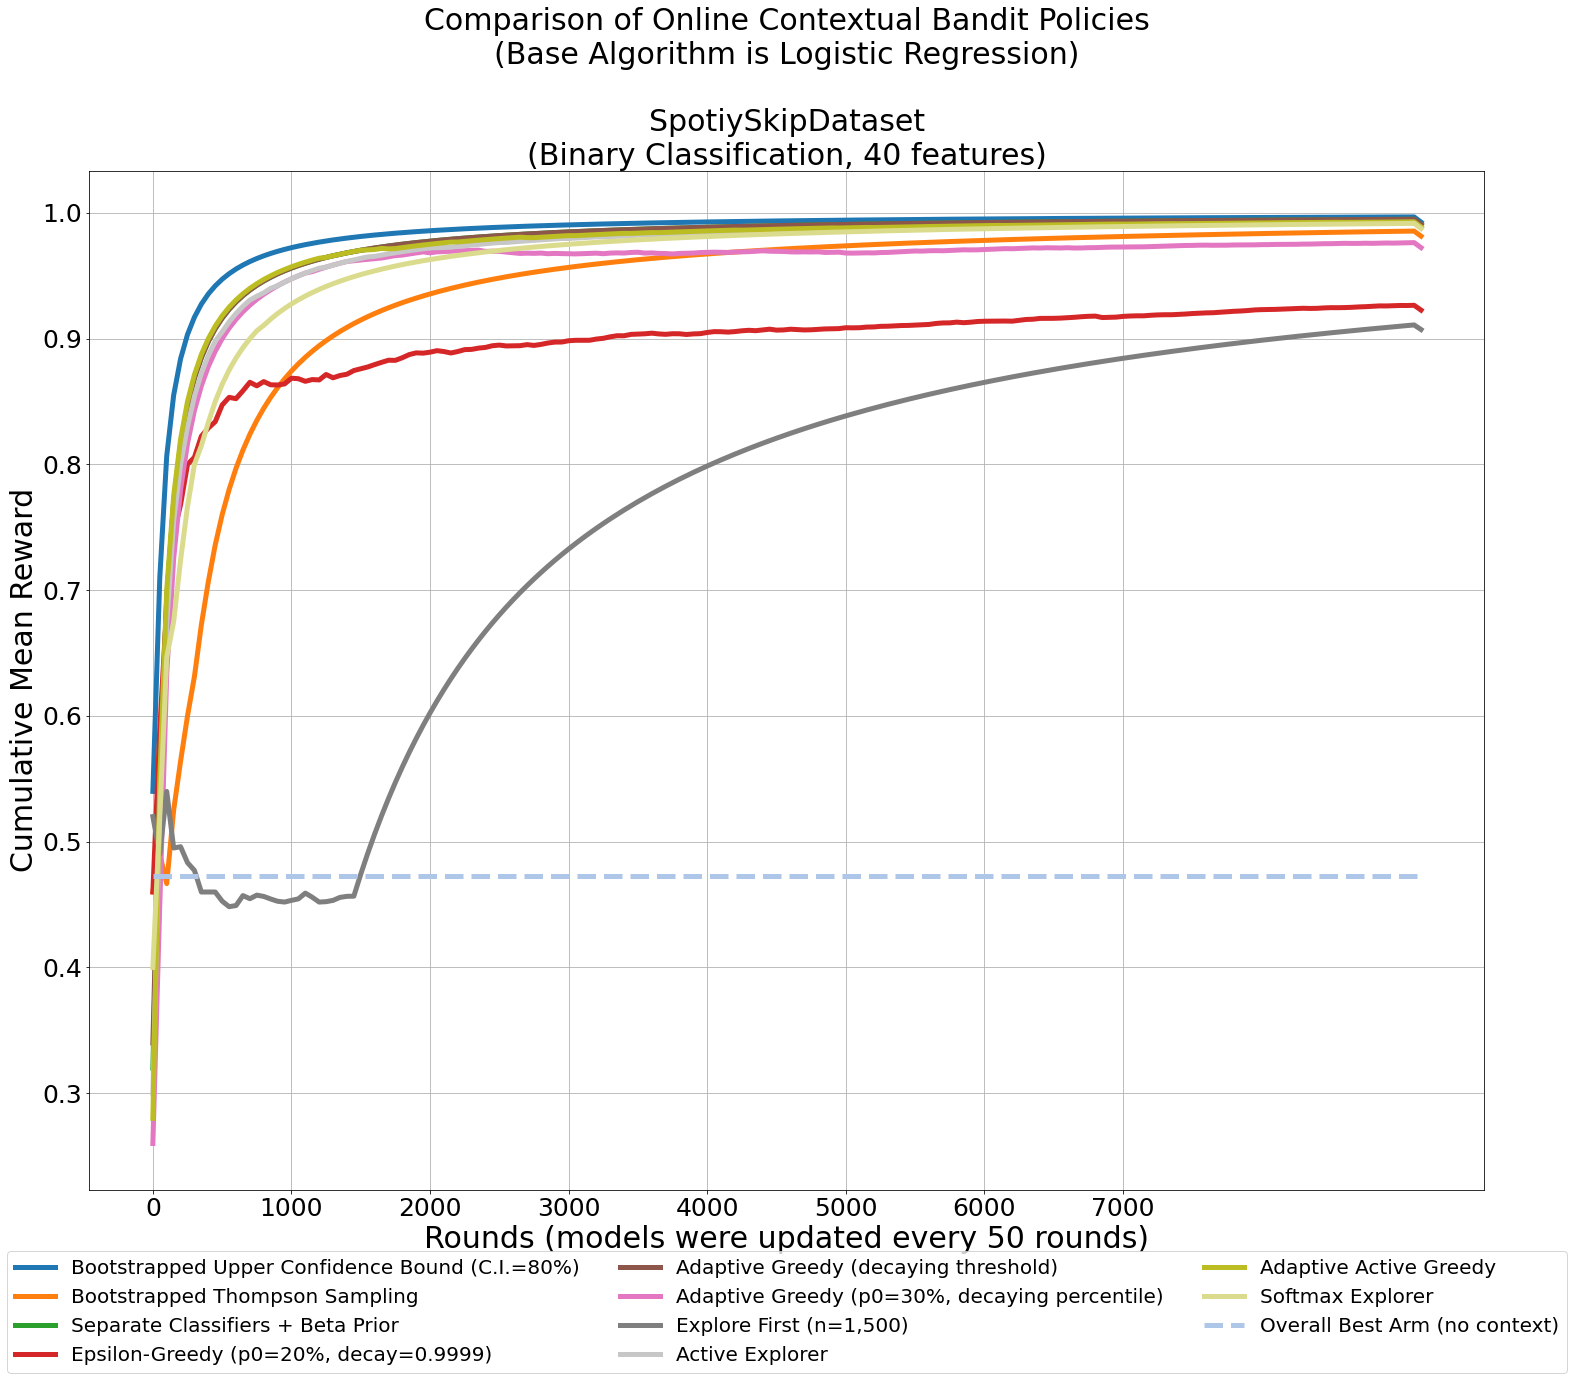

In [21]:
import matplotlib.pyplot as plt
from pylab import rcParams
%matplotlib inline

def get_mean_reward(reward_lst, batch_size=batch_size):
        mean_rew=list()
        for r in range(len(reward_lst)):
            mean_rew.append(sum(reward_lst[:r+1]) * 1.0 / ((r+1)*batch_size))
        return mean_rew
rcParams['figure.figsize'] = 25, 15
lwd = 5
cmap = plt.get_cmap('tab20')
colors=plt.cm.tab20(np.linspace(0, 1, 20))

ax = plt.subplot(111)
plt.plot(get_mean_reward(rewards_ucb), label="Bootstrapped Upper Confidence Bound (C.I.=80%)",linewidth=lwd,color=colors[0])
plt.plot(get_mean_reward(rewards_ts), label="Bootstrapped Thompson Sampling",linewidth=lwd,color=colors[2])
plt.plot(get_mean_reward(rewards_ovr), label="Separate Classifiers + Beta Prior",linewidth=lwd,color=colors[4])
plt.plot(get_mean_reward(rewards_egr), label="Epsilon-Greedy (p0=20%, decay=0.9999)",linewidth=lwd,color=colors[6])
plt.plot(get_mean_reward(rewards_agr), label="Adaptive Greedy (decaying threshold)",linewidth=lwd,color=colors[10])
plt.plot(get_mean_reward(rewards_agr2), label="Adaptive Greedy (p0=30%, decaying percentile)",linewidth=lwd,color=colors[12])
plt.plot(get_mean_reward(rewards_efr), label="Explore First (n=1,500)",linewidth=lwd,color=colors[14])
plt.plot(get_mean_reward(rewards_ac), label="Active Explorer", linewidth=lwd,color=colors[15])
plt.plot(get_mean_reward(rewards_aac), label="Adaptive Active Greedy", linewidth=lwd,color=colors[16])
plt.plot(get_mean_reward(rewards_sft), label="Softmax Explorer", linewidth=lwd,color=colors[17])
plt.plot(np.repeat(y.mean(axis=0).max(),len(rewards_sft)), label="Overall Best Arm (no context)",linewidth=lwd,color=colors[1],ls='dashed')

# import warnings\n",
box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                     box.width, box.height * 1.25])
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, ncol=3, prop={'size':20})

plt.tick_params(axis='both', which='major', labelsize=25)
plt.xticks([i*20 for i in range(8)], [i*1000 for i in range(8)])

plt.xlabel('Rounds (models were updated every 50 rounds)', size=30)
plt.ylabel('Cumulative Mean Reward', size=30)
plt.title('Comparison of Online Contextual Bandit Policies\n(Base Algorithm is Logistic Regression)\n\nSpotiySkipDataset\n(Binary Classification, 40 features)',size=30)
plt.grid()
plt.show()